In [1]:
%load_ext autoreload
%autoreload 2
%cd ../../

/mainfs/home/jd5u19/progressive-tradeoff


In [2]:

import numpy as np
from torchvision import transforms
import torch
import json

from main.utils.analysis_utils import get_distribution
from main.utils.confidence_utils import fgsm_attack
from main.utils.get_data import get_dataset
# from main.utils.get_model import create_model,attach_branches

# from main.utils.utils import branch_ce_loss, branch_dirichlet_loss, branch_dirichlet_ensemble_loss, branch_metric_loss, get_branched_accuracies, set_unique_exp_name

import matplotlib.pyplot as plt
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
plt.style.use('seaborn-colorblind')

# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

height = 8
width = height*1.6
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 25

def get_model_params(directory):
    model_param_file = open(directory + '/model_params.json')
    model_params = json.load(model_param_file)
    if 'loss' not in model_params.keys():
        model_params['loss'] = 'cross-entropy'
    return model_params

def get_label(labels,label):
    if label in labels:
        label = label+'_'+str(2)
        for i in range(3,10):
            if label in labels:
                label = label+'_'+str(i)
            else:
                break
    labels.append(label)
    return labels,label

In [4]:
#load in dataset and model for analysis

# model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/KL-decrease-lr001-dirichlet-loss/'
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/overconf_analysis_1'

dataset = model_directory.split('/')[1]
_,_,test_loader,data_props = get_dataset(dataset,batch_size=1)

labels = data_props['meta']['label_names'] 

_,_,cifar100_test_loader,cifar100_data_props = get_dataset('CIFAR100',batch_size=1)
labels_cifar100 = cifar100_data_props['meta']['fine_label_names'] 

model_params = get_model_params(model_directory)

n_branches = model_params['n_branches']


In [5]:
# dont really need these components

# backbone = create_model(model_params)
# model = attach_branches(model_params,backbone,n_branches) 
# n_classes = model_params['n_classes']

# loss = model_params['loss']


#defining our branched loss
# if loss == 'cross-entropy':
#     weight_dict = {'final_weight':0.4}
#     branched_loss = branch_ce_loss(weights='weighted-final',n_branches=model_params['n_branches'],**weight_dict)
# elif loss == 'dirichlet-loss':
#     weight_dict = {'final_weight':0.4}
#     annealing_step = 1
#     branched_loss = branch_dirichlet_loss(weights='weighted-final',n_branches=model_params['n_branches'],n_classes = n_classes, global_step=0, annealing_step=annealing_step, **weight_dict)
# elif loss == 'dirichlet-ensemble-loss':
#     weight_dict = {'final_weight':0.4}
#     annealing_step = 1
#     branched_loss = branch_dirichlet_ensemble_loss(weights='weighted-final',n_branches=n_branches,n_classes = n_classes, global_step=0, annealing_step=annealing_step, **weight_dict)
# elif loss == 'metric-loss':
#     weight_dict = {'final_weight':0.4}
#     annealing_step = 1
#     branched_loss = branch_metric_loss(weights='weighted-final',n_branches=n_branches,n_classes = n_classes, global_step=0, annealing_step=annealing_step, **weight_dict)
# else:
#     weight_dict = {'final_weight':0.4}
#     branched_loss = branch_ce_loss(weights='weighted-final',n_branches=model_params['n_branches'],**weight_dict)

In [6]:
#transform that un-normalises the data so its easier to see the effect of the perturbation

plotting_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.201],std=[1/0.2023, 1/0.1994, 1/0.201]),
    transforms.ToPILImage()
    ])

epsilon = 0.4



#uncomment to get new input

# input, target = next(iter(test_loader))  

#get perturbed input

# input.requires_grad = True
# output = model(input)
# loss,_ = branched_loss(output,target)
# model.zero_grad()
# loss = loss.backward()
# data_grad = input.grad.data
# perturbed_input = fgsm_attack(input,epsilon,data_grad)

#compare images

# plt.title('example: ',labels)
# plt.subplot(1,2,1)
# plt.title('orginal')
# image = input[0]
# plt.imshow(plotting_transform(image))

# plt.subplot(1,2,2)
# plt.title('perturbed $\epsilon$ ='+str(epsilon))
# perturbed_image = perturbed_input[0]
# plt.imshow(plotting_transform(perturbed_image))
# plt.show()

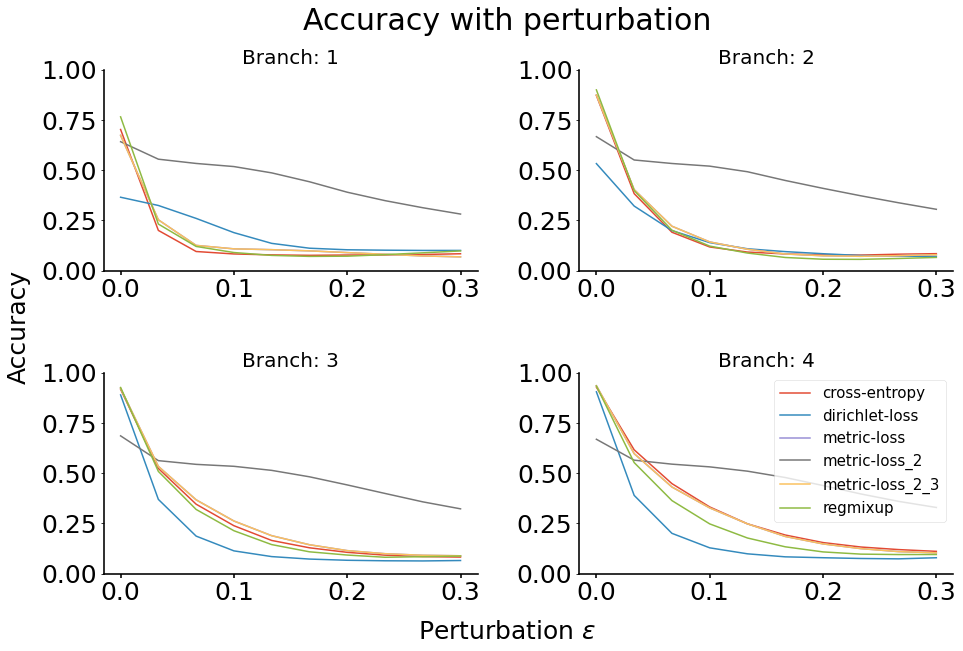

In [7]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/overconf_analysis_1'
directories = ['trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch-val-set','trained-models/CIFAR10/resnet_4_branch/w1.0_d18/resolution-dependant-lr005-dirichlet-loss','trained-models/CIFAR10/resnet_4_branch/w1.0_d18/annealing-decrease-metric-loss/','trained-models/CIFAR10/resnet_4_branch/w1.0_d18/loss-normaliser-metric-loss','trained-models/CIFAR10/resnet_4_branch/w1.0_d18/annealing-decrease-metric-loss/','trained-models/CIFAR10/resnet_4_branch/w1.0_d18/01-regmixup-regmixup-loss']

fig, axes = plt.subplots(nrows=2, ncols=2)
labels = list()
for dir_idx,directory in enumerate(directories):
    model_params = get_model_params(directory)
    label = model_params['loss']
    labels,label = get_label(labels,label)

    dataset = directory.split('/')[1]
    _,_,_,data_props = get_dataset(dataset,batch_size=1)

    n_samples = data_props['n_values_test']
    n_branches = model_params['n_branches']
    n_runs = 3

    
    epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
    n_epsilon = len(epsilons)
    accuracies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))
    entropies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))

    for run in range(3):
        accuracies[:,:,:,run] = np.load(directory+'/adversarial_analysis/accuracies.npy')
        entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

    accuracies_mean = np.mean(np.mean(accuracies,axis=0),axis=-1)
    accuracies_std = np.std(np.mean(accuracies,axis=0),axis=-1)

    for idx,ax in enumerate(axes.ravel()):
        mean = accuracies_mean[idx,:]
        std = accuracies_std[idx,:]
        ax.set_ylim(0,1)
        ax.set_title('Branch: ' + str(idx+1),fontsize=20)
        ax.plot(epsilons,mean,label=label)
        ax.fill_between(epsilons,mean+std,mean-std,alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

fig.text(0.5, 1.03, 'Accuracy with perturbation', ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.03, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.03, 'Perturbation $\epsilon$', ha='center', va='center', rotation='horizontal')
plt.show()



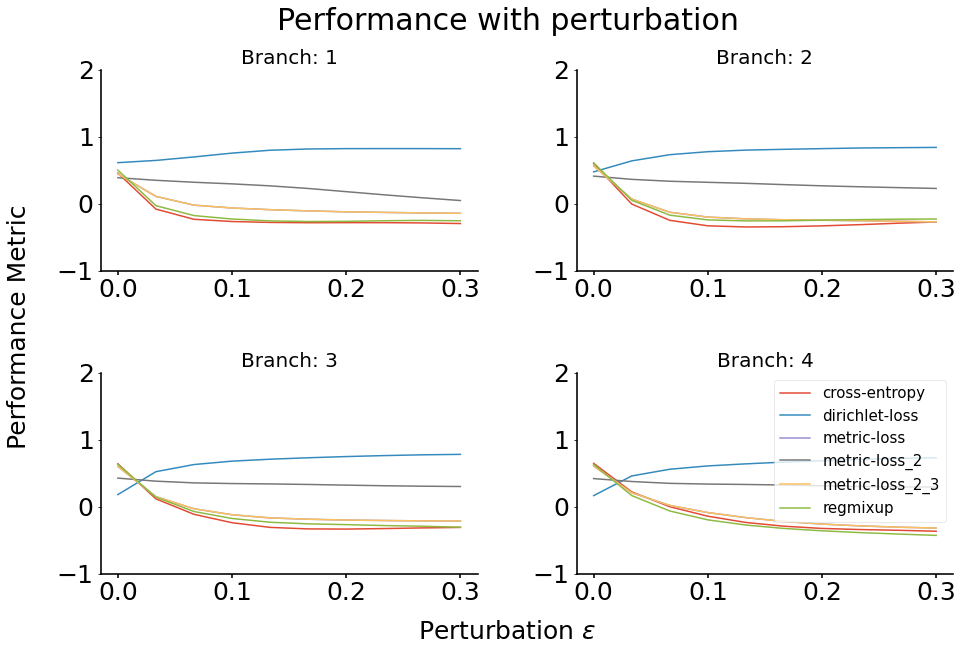

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2)

labels = list()
for dir_idx,directory in enumerate(directories):
    model_params = get_model_params(directory)
    label = model_params['loss']
    labels,label = get_label(labels,label)

    dataset = directory.split('/')[1]
    _,_,_,data_props = get_dataset(dataset,batch_size=1)

    n_samples = data_props['n_values_test']
    n_branches = model_params['n_branches']
    n_runs = 3

    
    epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
    n_epsilon = len(epsilons)
    accuracies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))
    entropies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))

    for run in range(3):
        accuracies[:,:,:,run] = np.load(directory+'/adversarial_analysis/accuracies.npy')
        entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

    accuracies_metric = accuracies.copy()
    accuracies_metric[accuracies_metric==0] = -1
    
    mistakes = (-1)*(accuracies - 1)
    confidences = 1-np.mean(entropies)

    correct_metric = accuracies_metric*confidences 
    incorrect_metric = mistakes*entropies

    metric = correct_metric + incorrect_metric

    mean_metric = np.mean(np.mean(metric,axis=0),axis=-1)
    std_metric = np.std(np.mean(metric,axis=0),axis=-1)

    for idx,ax in enumerate(axes.ravel()):
        mean = mean_metric[idx,:]
        std = std_metric[idx,:]
        ax.set_ylim(-1,2)
        ax.set_title('Branch: ' + str(idx+1),fontsize=20)
        ax.plot(epsilons,mean,label=label)
        ax.fill_between(epsilons,mean+std,mean-std,alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

fig.text(0.5, 1.03, 'Performance with perturbation', ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.03, 0.5, 'Performance Metric', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.03, 'Perturbation $\epsilon$', ha='center', va='center', rotation='horizontal')
plt.show()

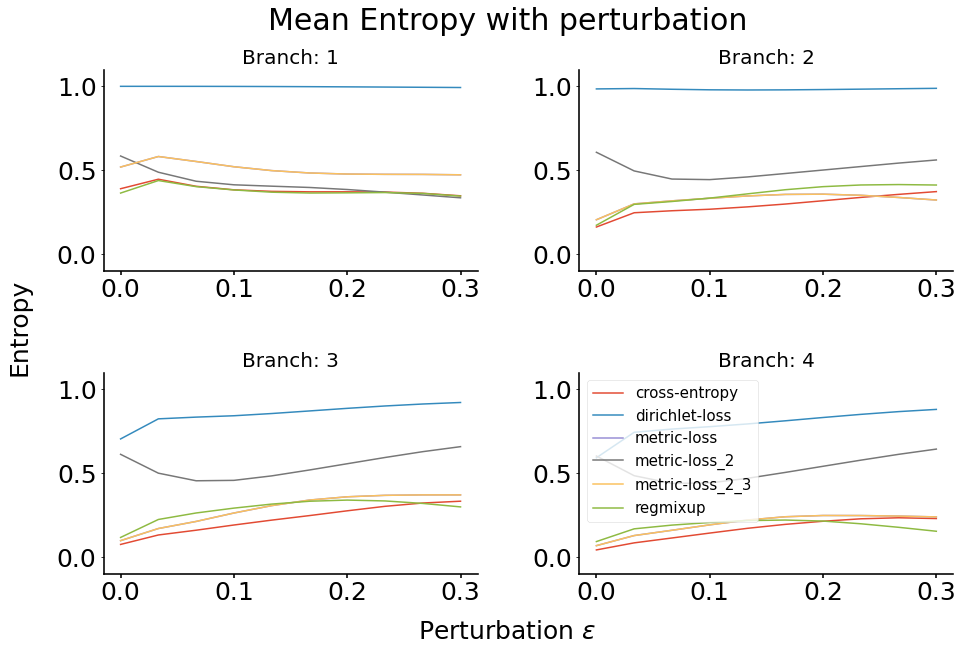

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2)

labels = list()
for dir_idx,directory in enumerate(directories):
    model_params = get_model_params(directory)
    label = model_params['loss']
    labels,label = get_label(labels,label)

    dataset = directory.split('/')[1]
    _,_,_,data_props = get_dataset(dataset,batch_size=1)

    n_samples = data_props['n_values_test']
    n_branches = model_params['n_branches']
    n_classes = model_params['n_classes']
    n_runs = 3

    entropies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))

    epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
    for run in range(3):
        entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

    entropies_mean = np.mean(np.mean(entropies,axis=0),axis=-1)
    entropies_std = np.std(np.mean(entropies,axis=0),axis=-1)

    for idx,ax in enumerate(axes.ravel()):
        mean = entropies_mean[idx,:]
        std = entropies_std[idx,:]
        ax.set_ylim(-0.1,1.1)
        ax.set_title('Branch: ' + str(idx+1),fontsize=20)
        ax.plot(epsilons,mean,label=label)
        ax.fill_between(epsilons,mean+std,mean-std,alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

fig.text(0.5, 1.03, 'Mean Entropy with perturbation', ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.03, 0.5, 'Entropy', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.03, 'Perturbation $\epsilon$', ha='center', va='center', rotation='horizontal')
plt.show()

# epsilons = np.load(model_directory+'/adversarial_analysis/epsilons.npy')
# entropies = np.zeros((n_samples,n_branches,n_classes,n_runs))

# for run in range(3):
#     entropies[:,:,:,run] = np.load(model_directory+'/adversarial_analysis/entropies.npy')

# mean_entropies = np.mean(np.mean(entropies,axis=0),axis=-1)
# std_entropies = np.std(np.mean(entropies,axis=0),axis=-1)

# plt.title('Mean Entropy with Perturbation: '+loss)
# for branch in range(n_branches):
#     mean = mean_entropies[branch,:]
#     std = std_entropies[branch,:]
#     plt.plot(epsilons,mean,label=('Branch: ' + str(branch+1)))
#     plt.fill_between(epsilons,mean+std,mean-std,alpha=0.5)
# plt.xlabel('Purturbation $\epsilon$')
# plt.ylabel('Mean entropy')
# plt.legend()
# plt.show()

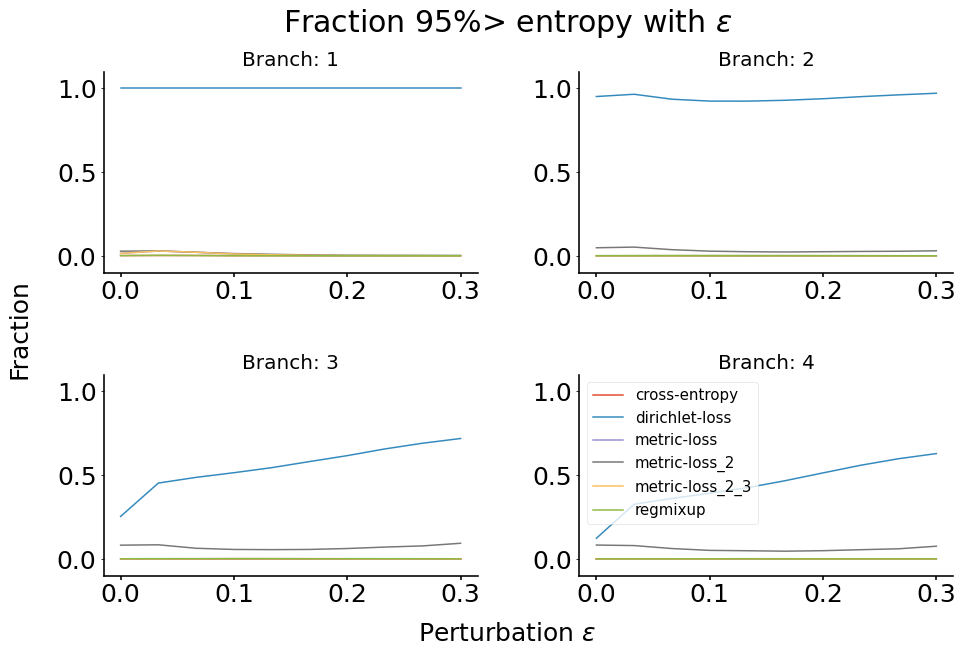

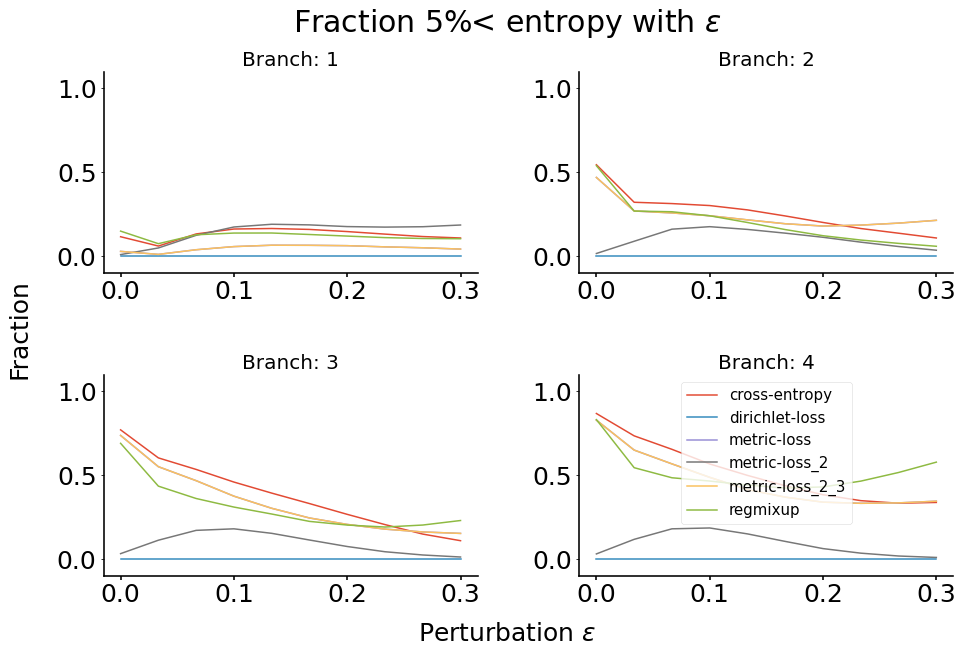

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)

labels = list()
for dir_idx,directory in enumerate(directories):
    model_params = get_model_params(directory)
    label = model_params['loss']
    labels,label = get_label(labels,label)

    dataset = directory.split('/')[1]
    _,_,_,data_props = get_dataset(dataset,batch_size=1)

    n_samples = data_props['n_values_test']
    n_branches = model_params['n_branches']
    n_classes = model_params['n_classes']
    n_runs = 3

    entropies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))

    epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
    for run in range(3):
        entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

    entropies_mean = np.mean(np.mean(entropies>0.9,axis=0),axis=-1)
    entropies_std = np.std(np.mean(entropies>0.9,axis=0),axis=-1)

    for idx,ax in enumerate(axes.ravel()):
        mean = entropies_mean[idx,:]
        std = entropies_std[idx,:]
        ax.set_ylim(-0.1,1.1)
        ax.set_title('Branch: ' + str(idx+1),fontsize=20)
        ax.plot(epsilons,mean,label=label)
        ax.fill_between(epsilons,mean+std,mean-std,alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

fig.text(0.5, 1.03, 'Fraction 95%> entropy with $\epsilon$', ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.03, 0.5, 'Fraction', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.03, 'Perturbation $\epsilon$', ha='center', va='center', rotation='horizontal')
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2)

labels = list()
for dir_idx,directory in enumerate(directories):
    model_params = get_model_params(directory)
    label = model_params['loss']
    labels,label = get_label(labels,label)

    dataset = directory.split('/')[1]
    _,_,_,data_props = get_dataset(dataset,batch_size=1)

    n_samples = data_props['n_values_test']
    n_branches = model_params['n_branches']
    n_classes = model_params['n_classes']
    n_runs = 3

    entropies = np.zeros((n_samples,n_branches,n_epsilon,n_runs))

    epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
    for run in range(3):
        entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

    entropies_mean = np.mean(np.mean(entropies<0.1,axis=0),axis=-1)
    entropies_std = np.std(np.mean(entropies<0.1,axis=0),axis=-1)

    for idx,ax in enumerate(axes.ravel()):
        mean = entropies_mean[idx,:]
        std = entropies_std[idx,:]
        ax.set_ylim(-0.1,1.1)
        ax.set_title('Branch: ' + str(idx+1),fontsize=20)
        ax.plot(epsilons,mean,label=label)
        ax.fill_between(epsilons,mean+std,mean-std,alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

fig.text(0.5, 1.03, 'Fraction 5%< entropy with $\epsilon$', ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.03, 0.5, 'Fraction', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.03, 'Perturbation $\epsilon$', ha='center', va='center', rotation='horizontal')
plt.show()


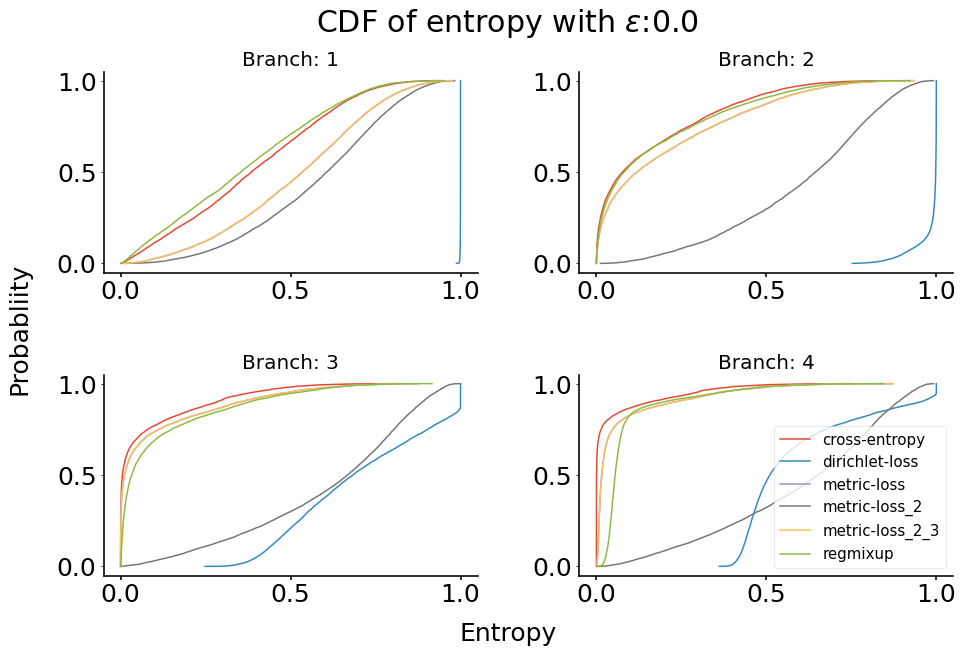

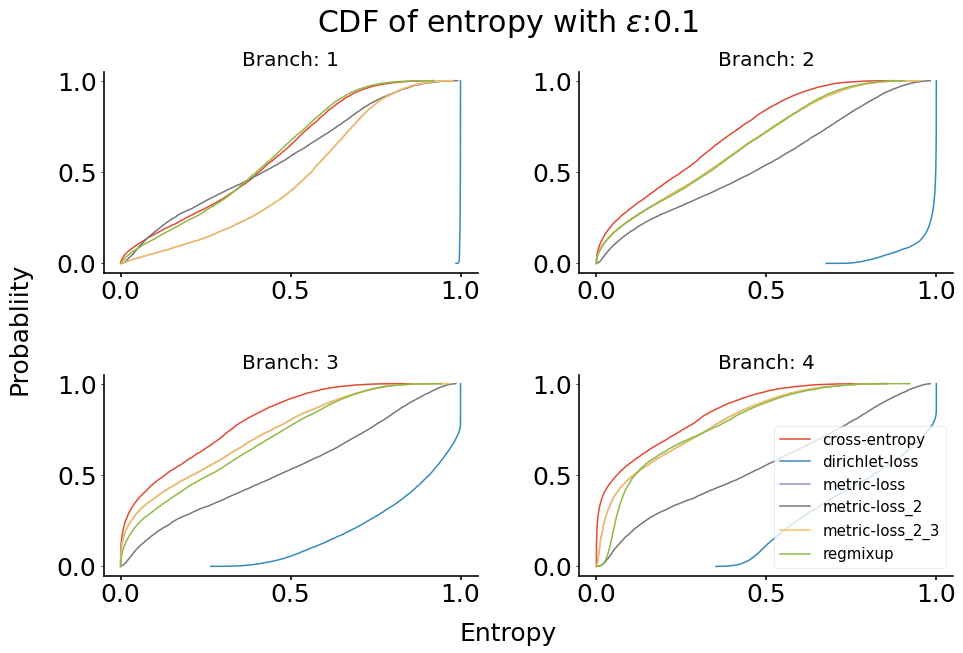

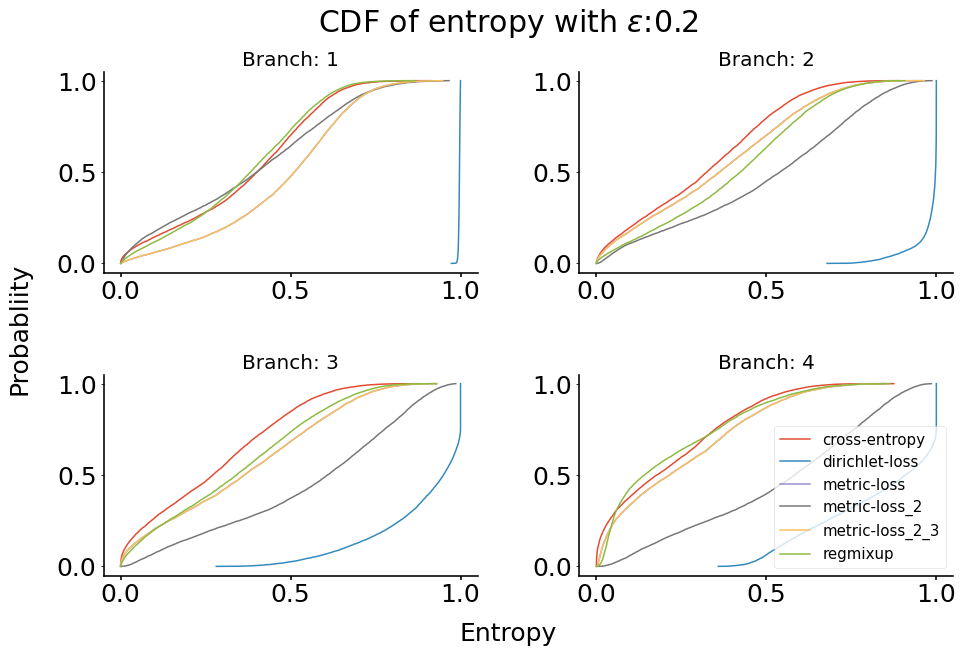

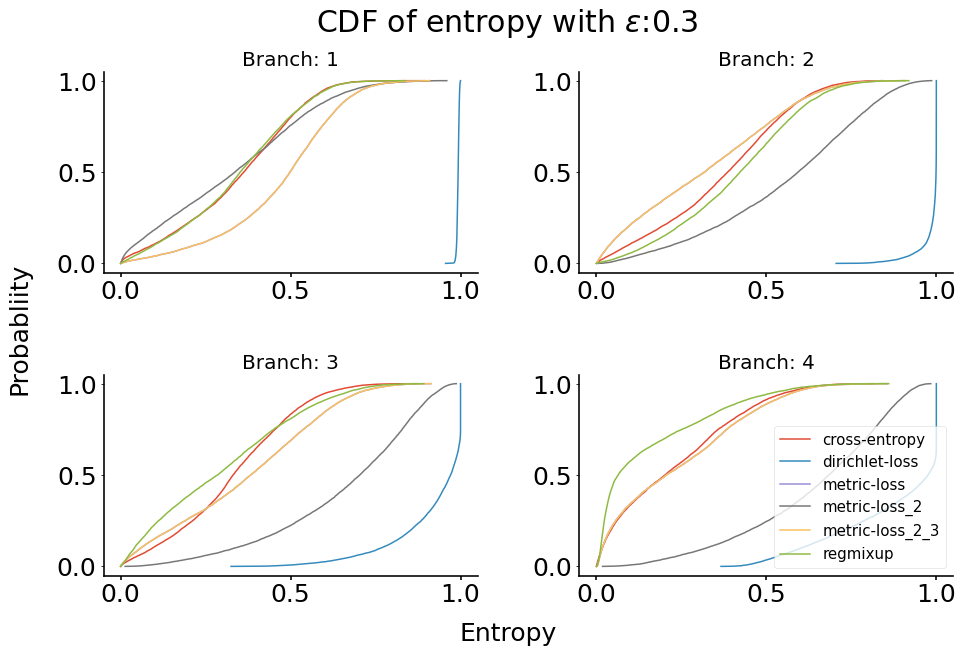

In [11]:
for epsilon_idx in range(0,10,3):
    fig, axes = plt.subplots(nrows=2, ncols=2)

    labels = list()
    for dir_idx,directory in enumerate(directories):
        model_params = get_model_params(directory)
        label = model_params['loss']
        labels,label = get_label(labels,label)

        dataset = directory.split('/')[1]
        _,_,_,data_props = get_dataset(dataset,batch_size=1)

        n_samples = data_props['n_values_test']
        n_branches = model_params['n_branches']
        n_classes = model_params['n_classes']
        n_runs = 3

        entropies = np.zeros((n_samples,n_branches,n_classes,n_runs))

        epsilons = np.load(directory+'/adversarial_analysis/epsilons.npy')
        for run in range(3):
            entropies[:,:,:,run] = np.load(directory+'/adversarial_analysis/entropies.npy')

        entropies_mean = np.mean(entropies,axis=-1)

        for idx,ax in enumerate(axes.ravel()):

            mean = entropies_mean[:,idx,epsilon_idx]

            # ax.set_ylim(-0.1,1.1)
            ax.set_title('Branch: ' + str(idx+1),fontsize=20)
            ax.plot(np.sort(mean), np.linspace(0, 1, len(mean), endpoint=False),label=label)
            

    plt.legend(fontsize=15)
    plt.tight_layout(pad=0.4, w_pad=2.0, h_pad=2.0)

    fig.text(0.5, 1.03, ('CDF of entropy with $\epsilon$:'+str(epsilons[epsilon_idx])), ha='center', va='center', rotation='horizontal',fontsize=30)
    fig.text(-0.03, 0.5, 'Probabliity', ha='center', va='center', rotation='vertical')
    fig.text(0.5, -0.03, 'Entropy', ha='center', va='center', rotation='horizontal')
    plt.show()

/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


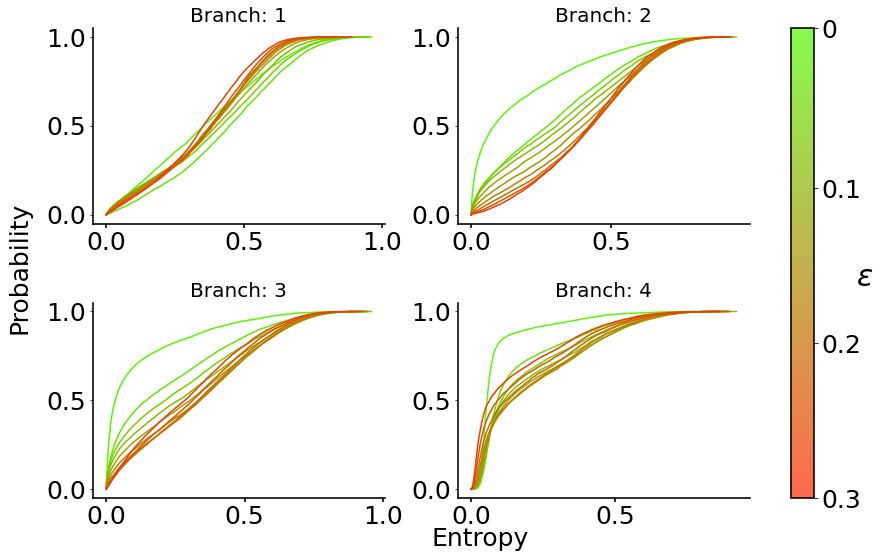

In [12]:
n_thresh = 100
thresholds = np.linspace(0,100,n_thresh)

green = np.array([83, 250, 0])/255
red = np.array([255, 40, 0])/255
n = 256  # number of values in the colormap
color_list = [green + (red - green) * i / (n - 1) for i in range(n)]
cmap = plt.cm.colors.ListedColormap(color_list[::-1])

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/'

entropies = np.load(directory+'/adversarial_analysis/entropies.npy')
epsilons  = np.load(directory+'/adversarial_analysis/epsilons.npy')

n_tests = epsilons.shape[0]
n_branches = entropies.shape[1]

fig, axes = plt.subplots(2,int(n_branches/2))

for epsilon_idx,epsilon in enumerate(epsilons):
    test_entropies = entropies[:,:,epsilon_idx]
    for branch,ax in enumerate(axes.flatten()):
        mean = test_entropies[:,branch]
        ax.set_title('Branch: ' + str(branch+1),fontsize=20)
        ax.plot(np.sort(mean), np.linspace(0, 1, len(mean),endpoint=False),color=cmap(1-(epsilon_idx/n_tests)),label=label)
        

fig.text(0.0, 0.5, 'Probability', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.03, 'Entropy', ha='center', va='center', rotation='horizontal')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right', pad=0.05)
cbar.set_alpha(0.7)
cbar.draw_all()

cbar.set_ticks([0,0.33,0.66,1])
cbar.set_ticklabels([0.3,0.2,0.1,0])

cbar.set_label('$\epsilon$',rotation=0)
plt.savefig('main/figures/adv_ent_cdf.pdf',bbox_inches='tight')
plt.show()

/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


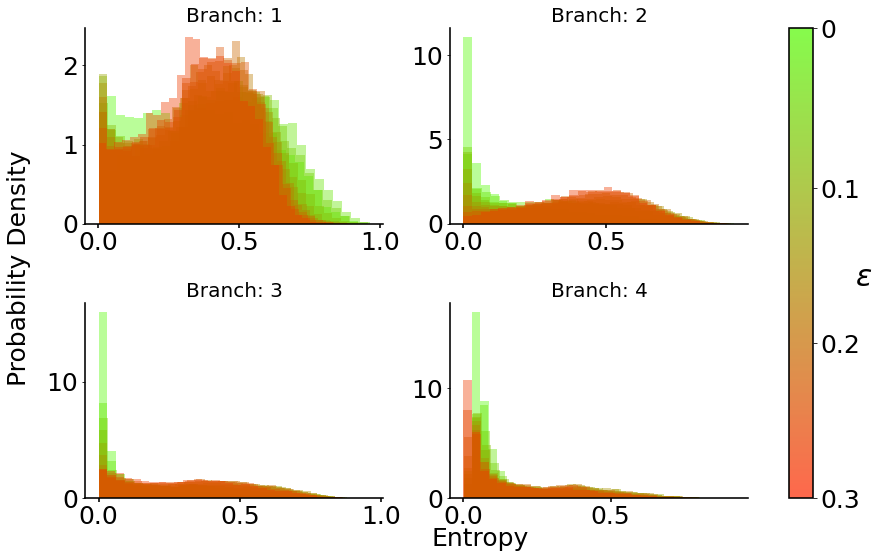

In [15]:
n_thresh = 100
thresholds = np.linspace(0,100,n_thresh)

green = np.array([83, 250, 0])/255
red = np.array([255, 40, 0])/255
n = 256  # number of values in the colormap
color_list = [green + (red - green) * i / (n - 1) for i in range(n)]
cmap = plt.cm.colors.ListedColormap(color_list[::-1])

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/'

entropies = np.load(directory+'/adversarial_analysis/entropies.npy')
epsilons  = np.load(directory+'/adversarial_analysis/epsilons.npy')

n_tests = epsilons.shape[0]
n_branches = entropies.shape[1]

fig, axes = plt.subplots(2,int(n_branches/2))

for epsilon_idx,epsilon in enumerate(epsilons):
    test_entropies = entropies[:,:,epsilon_idx]
    for branch,ax in enumerate(axes.flatten()):
        mean = test_entropies[:,branch]
        ax.set_title('Branch: ' + str(branch+1),fontsize=20)
        ax.hist(mean,alpha=0.4,bins=30,color=cmap(1-(epsilon_idx/n_tests)),density=True)
        

fig.text(0.0, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.03, 'Entropy', ha='center', va='center', rotation='horizontal')

plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right', pad=0.05)
cbar.set_alpha(0.7)
cbar.draw_all()

cbar.set_ticks([0,0.33,0.66,1])
cbar.set_ticklabels([0.3,0.2,0.1,0])

cbar.set_label('$\epsilon$',rotation=0)
plt.savefig('main/figures/adv_ent_hist.pdf',bbox_inches='tight')
plt.show()

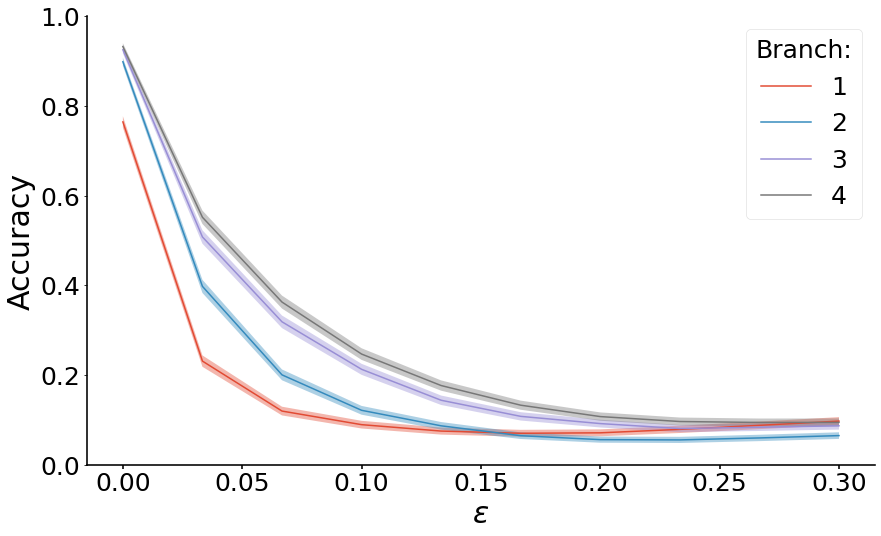

In [14]:

green = np.array([83, 250, 0])/255
red = np.array([255, 40, 0])/255
n = 256  # number of values in the colormap
color_list = [green + (red - green) * i / (n - 1) for i in range(n)]
cmap = plt.cm.colors.ListedColormap(color_list[::-1])

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/'

accuracies = np.load(directory+'/adversarial_analysis/accuracies.npy')
epsilons  = np.load(directory+'/adversarial_analysis/epsilons.npy')

n_tests = epsilons.shape[0]
n_branches = accuracies.shape[1]
n_samples = accuracies.shape[0]

for branch,ax in enumerate(axes.flatten()):
    mean = np.mean(accuracies[:,branch],axis=0)
    label= str(branch+1)
    plt.plot(epsilons,mean,label=label)
    standard_error = 3*np.sqrt((mean*(1-mean))/n_samples)
    plt.fill_between(epsilons,mean+standard_error,mean-standard_error,alpha=0.4)

plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('$\epsilon$')
plt.legend(title='Branch:')
plt.tight_layout()

plt.savefig('main/figures/adv_accs.pdf',bbox_inches='tight')
plt.show()